#### 이 실습은 [링크](https://wiserloner.tistory.com/1049)의 자료를 참고하여 구성하였습니다.

### 필요한 라이브러리를 불러옵니다. 

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.figsize'] = (12, 5)
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 먼저 샘플 이미지에 Data Augmentation을 적용했을 때 이미지의 모습을 살펴봅시다. 

### 꽃 이미지 한 장을 불러옵니다. 

Dataset tf_flowers downloaded and prepared to C:\Users\R12720\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


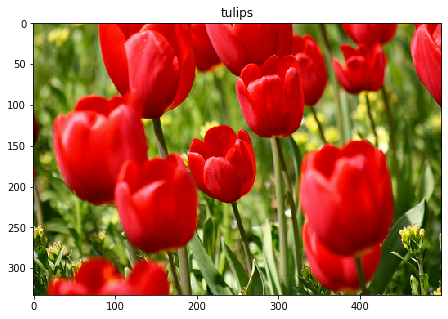

In [2]:
train_set, info = tfds.load(
    'tf_flowers',
    split='train',
    with_info=True,
    as_supervised=True,
)

get_label_name = info.features['label'].int2str

image, label = next(iter(train_set))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### 원본 이미지와 Augmented 이미지를 비교하는 함수를 작성하고 각각의 효과를 적용해 보겠습니다. 

In [ ]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

### flip_left_right : 이미지의 좌우를 바꾸는 효과입니다. 

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### adjust_saturation : 이미지의 채도를 바꾸는 효과입니다. 

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### random_brightness : 이미지의 밝기를 무작위로 바꾸는 효과입니다. 실행할 때마다 효과가 달라지는 것을 확인할 수 있습니다.

In [ ]:
bright = tf.image.random_brightness(image, max_delta=0.5)
visualize(image, bright)

### rot90 : 이미지를 90도만큼 회전합니다. argument에 따라 각도를 조절할 수 있습니다. 

In [ ]:
rotated = tf.image.rot90(image, k=1)
visualize(image, rotated)

### central_crop : 이미지의 중심 영역을 비율만큼 잘라냅니다. 

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.7)
visualize(image,cropped)

### 이미지에 augmentation을 적용했을 때의 효과를 확인했으므로, 실제 학습에는 어떤 효과가 있는지 확인해 보겠습니다.

### 0~9까지의 숫자로 이루어져 있는 MNIST 데이터셋을 이용하겠습니다. 데이터를 불러와 학습 데이터셋과 검증 데이터셋으로 나눕니다. 

In [ ]:
(train_set, val_set), info =  tfds.load('mnist', split=['train','test'], as_supervised=True, with_info=True)

n_train = info.splits['train'].num_examples

### 이미지를 normalize하는 convert 함수와 여러 augmentation 효과를 적용하는 augment 함수를 정의합니다. 

In [ ]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) 
    return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) 
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) 
  image = tf.image.random_crop(image, size=[28, 28, 1]) 
  image = tf.image.random_brightness(image, max_delta=0.5) 

  return image,label

### Augmentation을 적용한 학습 데이터셋을 생성합니다. 

In [ ]:
BATCH_SIZE = 64
NUM_EXAMPLES = 2048   # 이 실습에서는 데이터의 일부만 사용하겠습니다. 

aug_train_batches = (
    train_set
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(n_train//4)
    .map(augment, num_parallel_calls=AUTOTUNE)   # augment 함수를 적용합니다. 
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

### Augmentation을 적용했을 때의 학습 결과와 비교하기 위해 augmentation이 없을 때의 학습 데이터셋을 생성합니다. 

In [ ]:
no_aug_train_batches = (
    train_set
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(n_train//4)
    .map(convert, num_parallel_calls=AUTOTUNE)   # augmentation이 없으므로 normalize 함수만 적용합니다. 
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

### 검증 데이터셋을 생성합니다. 

In [ ]:
val_batches = (
    val_set
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

### 먼저 augmentation을 적용하지 않았을 때 모델 학습을 합니다. 

In [ ]:
no_aug_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(10)
])
no_aug_model.compile(optimizer = 'adam',
                     loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])
no_aug_history = no_aug_model.fit(no_aug_train_batches, epochs=40, validation_data=val_batches)

### 위에서 정의한 augmentation을 적용하여 모델 학습을 하겠습니다. 위와 동일한 모델입니다. 

In [ ]:
aug_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(10)
])
aug_model.compile(optimizer = 'adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
aug_history = aug_model.fit(aug_train_batches, epochs=40, validation_data=val_batches)

### 학습 결과를 비교해보겠습니다. 

In [ ]:
no_aug_acc = no_aug_history.history['accuracy']
no_aug_val_acc = no_aug_history.history['val_accuracy']
aug_acc = aug_history.history['accuracy']
aug_val_acc = aug_history.history['val_accuracy']

no_aug_loss = no_aug_history.history['loss']
no_aug_val_loss = no_aug_history.history['val_loss']
aug_loss = aug_history.history['loss']
aug_val_loss = aug_history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, no_aug_acc, 'r', label='No Aug Training')
plt.plot(epochs_range, no_aug_val_acc, '-.r', label='No Aug Validation')
plt.plot(epochs_range, aug_acc, 'b', label='Aug Training')
plt.plot(epochs_range, aug_val_acc, '-.b',label='Aug Validation')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.ylim([0.75,1])
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, no_aug_loss, 'r', label='No Aug Training')
plt.plot(epochs_range, no_aug_val_loss, '-.r', label='No Aug Validation')
plt.plot(epochs_range, aug_loss, 'b', label='Aug Training')
plt.plot(epochs_range, aug_val_loss, '-.b', label='Aug Validation')
plt.legend(loc='upper right')
plt.title('Loss')
plt.ylim([0,1])
plt.show()

### 두 모델의 차이는 augmentation의 적용 유무 뿐입니다. Augmentation을 적용하지 않은 경우는 오버피팅이 관찰되지만, augmentation을 적용하여 오버피팅을 줄이고 검증 데이터셋에 대한 성능이 높아진 것을 확인할 수 있습니다. 